# Market Price Driven Model

## Overview

The purpose of this experiment is to tune and test the PI controller, by driving the market price directly.

## Shared setup and dependencies

In [1]:
from pathlib import Path
import os

path = Path().resolve()
root_path = str(path).split('notebooks')[0]
os.chdir(root_path)

In [2]:
from shared import *

In [3]:
%pip show cadCAD

Name: cadCAD
Version: 0.4.23
Summary: cadCAD: a differential games based simulation software package for research, validation, and         Computer Aided Design of economic systems
Home-page: https://github.com/cadCAD-org/cadCAD
Author: Joshua E. Jodesty
Author-email: joshua@block.science
License: LICENSE.txt
Location: /Users/bscholtz/workspace/reflexer/venv/lib/python3.8/site-packages
Requires: pathos, fn, pandas, funcy
Required-by: 
Note: you may need to restart the kernel to use updated packages.


# Parameters

These are the key model parameters:
* `options.MarketPriceSource == options.MarketPriceSource.EXTERNAL`, with a step input sweep set as the market price external data source.

In [4]:
seconds_week = 604800
timesteps = int(10 * seconds_week / 3600)
control_period = 3600
shock_timestep = 1 * seconds_week / 3600
shock_duration = 5 * seconds_week / 3600

price_moves = [
    #lambda timestep: 0.01 if timestep == 50 else (-0.01 if timestep == 250 else 0),
    #lambda timestep: 0.05 if timestep == 50 else (-0.05 if timestep == 250 else 0),
    #lambda timestep: 0.1 if timestep == 50 else (-0.1 if timestep == 250 else 0)
    #lambda timestep, df=df.copy(): float(df.iloc[timestep - 1]['price_move'])
    #for df in debt_price_data,
    lambda timestep: 0.05 if timestep == shock_timestep else (-0.05 if timestep == shock_timestep + 1 else 0),
    lambda timestep: 0.05 if timestep == shock_timestep else (-0.05 if timestep == shock_timestep + shock_duration  else 0),
    lambda timestep: 0.05/50 * np.sin(timestep * 0.05)
]

* PI controller constant sweep

In [5]:
kp_sweep = [-1.5e-6]
ki_sweep = [lambda control_period=3600: 0]

# controller_sweep = list(itertools.product(kp_sweep, ki_sweep))
# controller_sweep

# kp_sweep = [x[0] for x in controller_sweep]
# ki_sweep = [x[1] for x in controller_sweep]

# print(kp_sweep)
# print(ki_sweep)

* Error term calculation

In [6]:
error_term = [
    lambda target, measured: target - measured,
    #lambda target, measured: (target - measured) / measured,
    #lambda target, measured: (target - measured) / target
]

* Integral type

In [7]:
integral_type = [options.IntegralType.DEFAULT.value]

## Simulation Configuration

Set the simulation timesteps to the minimum dataset length:

In [8]:
SIMULATION_TIMESTEPS = range(timesteps)

Override certain parameter sweeps with the generated sets, using ConfigWrapper for convenience:

In [9]:
# Update parameter options
update_params = {
    # By using an Enum, we can self-document all possible options
    options.MarketPriceSource.__name__: [options.MarketPriceSource.EXTERNAL.value],
    options.DebtPriceSource.__name__: [options.DebtPriceSource.DISABLED.value],
    options.IntegralType.__name__: integral_type,
    'controller_enabled': [True],
    'expected_control_delay': [lambda _timestep: 0], # 1200 # stochastic process
    'minumum_control_period': [lambda _timestep: control_period],
    # Generate a lambda for each test dataframe, that returns a row value at a specific timestep
    'price_move': price_moves,
    'kp': kp_sweep,
    'ki': ki_sweep,
    # Select or sweep the error term calculation, as a lambda
    # e.g. p*-p vs (p*-p)/p vs (p*-p)/p*
    'error_term': error_term,
}

update_initial_state = {
    'target_price': 1.0,
    'market_price': 1.0,
    'debt_price': 1.0,
}

'''
The ConfigWrapper allows you to pass a model as an argument, and update the simulation configuration.
Maps (params, states) would be merge updated, and all other options are overrides.
'''
system_simulation = ConfigWrapper(system_model_v1, M=update_params, initial_state=update_initial_state, T=SIMULATION_TIMESTEPS)

## Simulation Execution

In [10]:
del configs[:]

system_simulation.append()

(data, tensor_field, sessions) = run(drop_midsteps=True)


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (1680, 23, 3, 15)
Execution Method: local_simulations
SimIDs   : [0, 0, 0]
SubsetIDs: [0, 1, 2]
Ns       : [0, 1, 2]
ExpIDs   : [0, 0, 0]
Execution Mode: parallelized
Total execution time: 3.88s


## Data Analysis

In [11]:
df = data.copy()
df

,index,error_star,error_hat,old_error_star,old_error_hat,error_star_integral,error_hat_integral,error_star_derivative,error_hat_derivative,target_rate,...,market_price,debt_price,timedelta,timestamp,blockheight,simulation,subset,run,substep,timestep
0,0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,1.000000,1.0,0,2018-12-18 00:00:00,0,0,0,1,0,0
1,6,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,1.000000,1.0,3600,2018-12-18 01:00:00,240,0,0,1,6,1
2,12,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,1.000000,1.0,3600,2018-12-18 02:00:00,480,0,0,1,6,2
3,18,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,1.000000,1.0,3600,2018-12-18 03:00:00,720,0,0,1,6,3
4,24,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,1.000000,1.0,3600,2018-12-18 04:00:00,960,0,0,1,6,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5038,30218,-0.011792,-0.029983,0.0,0.0,-12039.716717,-119363.341318,-2.273070e-07,-2.273070e-07,1.768759e-08,...,1.030837,1.0,3600,2019-02-25 20:00:00,402240,0,2,2,6,1676
5039,30224,-0.012581,-0.030837,0.0,0.0,-12083.586843,-119472.816528,-2.191221e-07,-2.191221e-07,1.887085e-08,...,1.031663,1.0,3600,2019-02-25 21:00:00,402480,0,2,2,6,1677
5040,30230,-0.013338,-0.031663,0.0,0.0,-12130.240203,-119585.316194,-2.103892e-07,-2.103892e-07,2.000695e-08,...,1.032461,1.0,3600,2019-02-25 22:00:00,402720,0,2,2,6,1678
5041,30236,-0.014062,-0.032461,0.0,0.0,-12179.560208,-119700.739053,-2.011303e-07,-2.011303e-07,2.109305e-08,...,1.033227,1.0,3600,2019-02-25 23:00:00,402960,0,2,2,6,1679


In [12]:
# Export CSV market_price dataset
df.query('subset == 1')['market_price'].to_csv('tests/data/market_prices.csv')

In [13]:
df['target_rate_hourly'] = df.target_rate # * 3600
df['error_star_derivative_scaled'] = df.error_star_derivative * 3600
df['error_hat_derivative_scaled'] = df.error_star_derivative * 3600

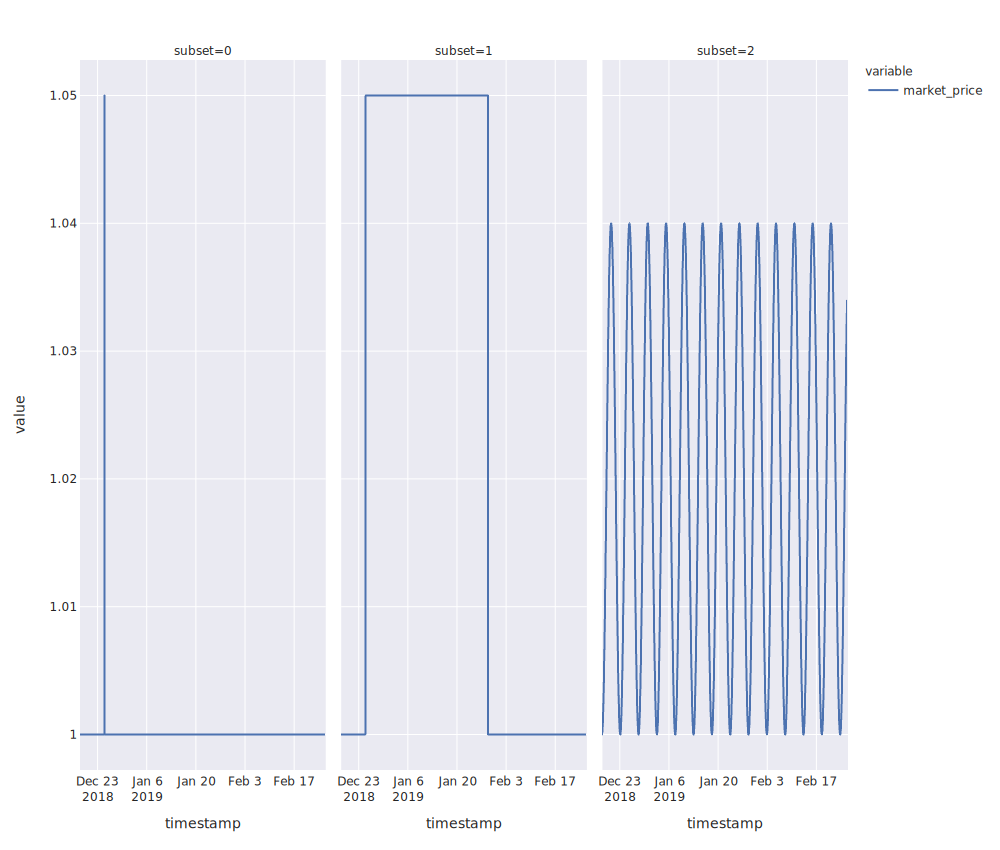

In [14]:
fig = px.line(
    df,
    x='timestamp',
    y=['market_price'],
    facet_col='subset',
    facet_col_wrap=3,
    template='seaborn',
    height=800
)

# fig.show()
fig.write_image('plots/notebook_validation_market_price/market_price.svg', width=1000, height=850)
from IPython.display import SVG,display
display(SVG(filename='plots/notebook_validation_market_price/market_price.svg'))

In [15]:
fig = px.line(
    df,
    x='timestamp',
    y=['target_price', 'market_price'],
    facet_col_wrap=3,
    facet_col='subset',
    template='seaborn',
    height=800
)

fig.show()
fig.write_image('plots/notebook_validation_market_price/response.png', width=1000, height=850)
# from IPython.display import SVG,display
# display(SVG(filename='plots/notebook_validation_market_price/response.svg'))

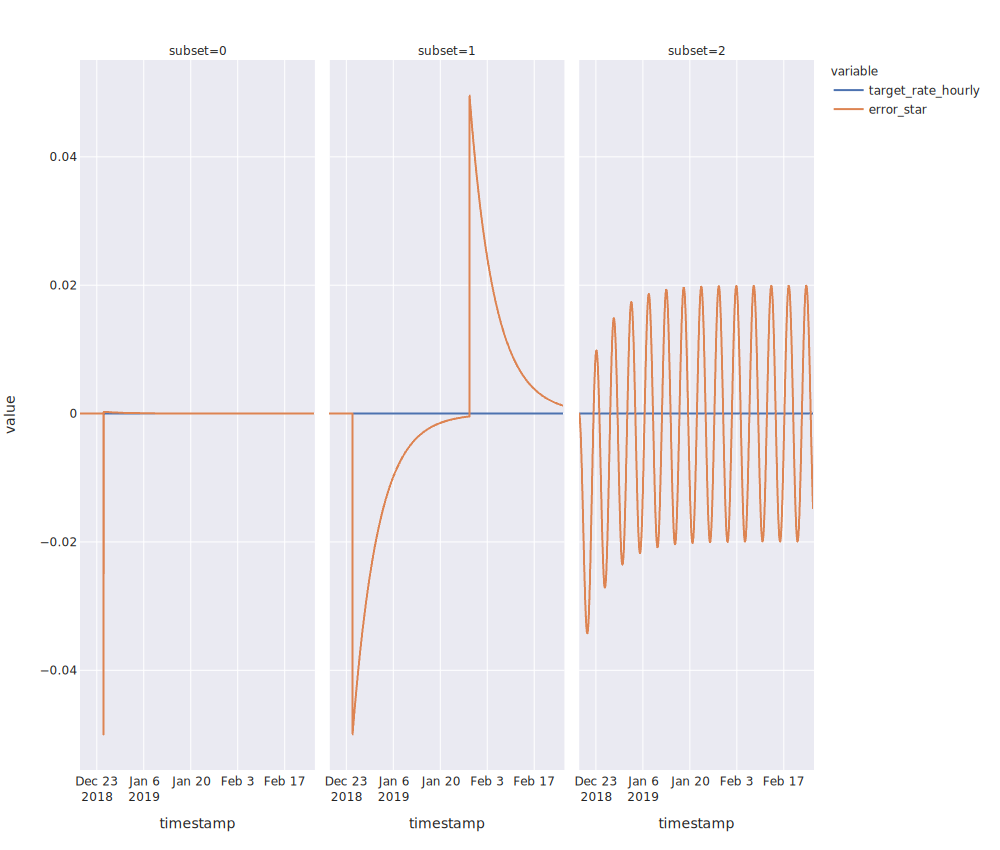

In [16]:
fig = px.line(
    df,
    x='timestamp',
    y=['target_rate_hourly', 'error_star'],
    facet_col='subset',
    facet_col_wrap=3,
    template='seaborn',
    height=800
)

# fig.show()
fig.write_image('plots/notebook_validation_market_price/target_rate.svg', width=1000, height=850)
from IPython.display import SVG,display
display(SVG(filename='plots/notebook_validation_market_price/target_rate.svg'))

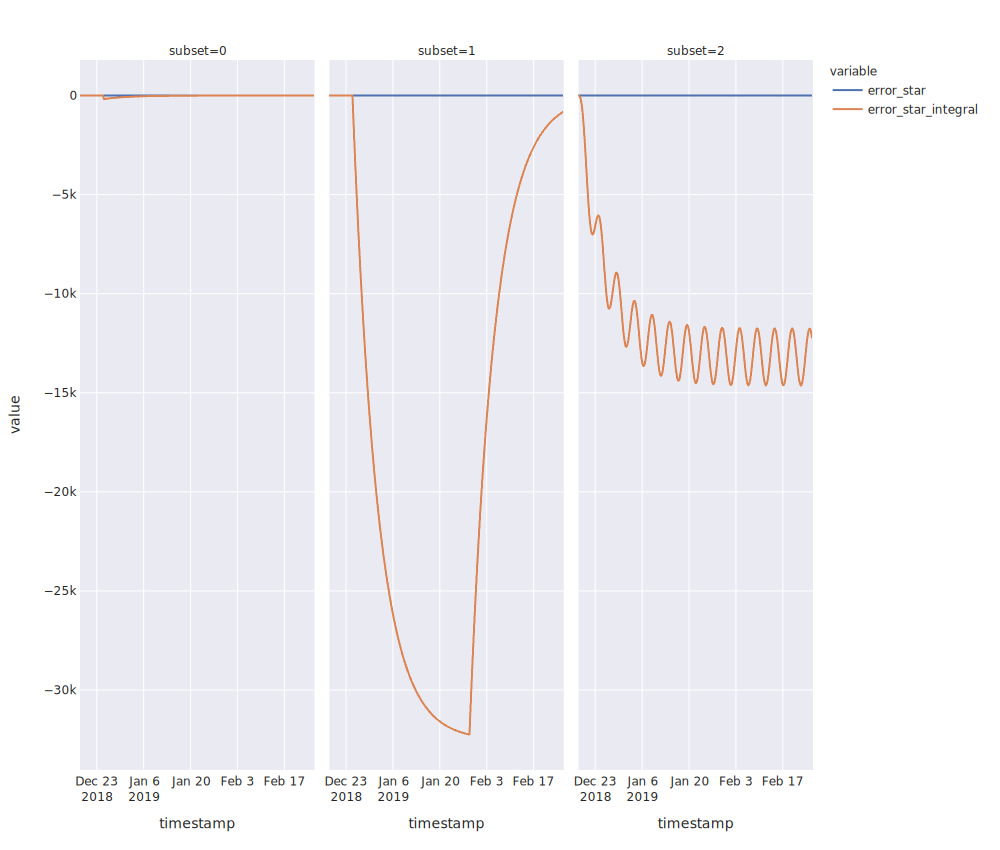

In [17]:
fig = px.line(
    df,
    x='timestamp',
    y=['error_star', 'error_star_integral'],
    facet_col='subset',
    facet_col_wrap=3,
    template='seaborn',
    height=800
)

# fig.show()
fig.write_image('plots/notebook_validation_market_price/error_star.svg', width=1000, height=850)
from IPython.display import SVG,display
display(SVG(filename='plots/notebook_validation_market_price/error_star.svg'))

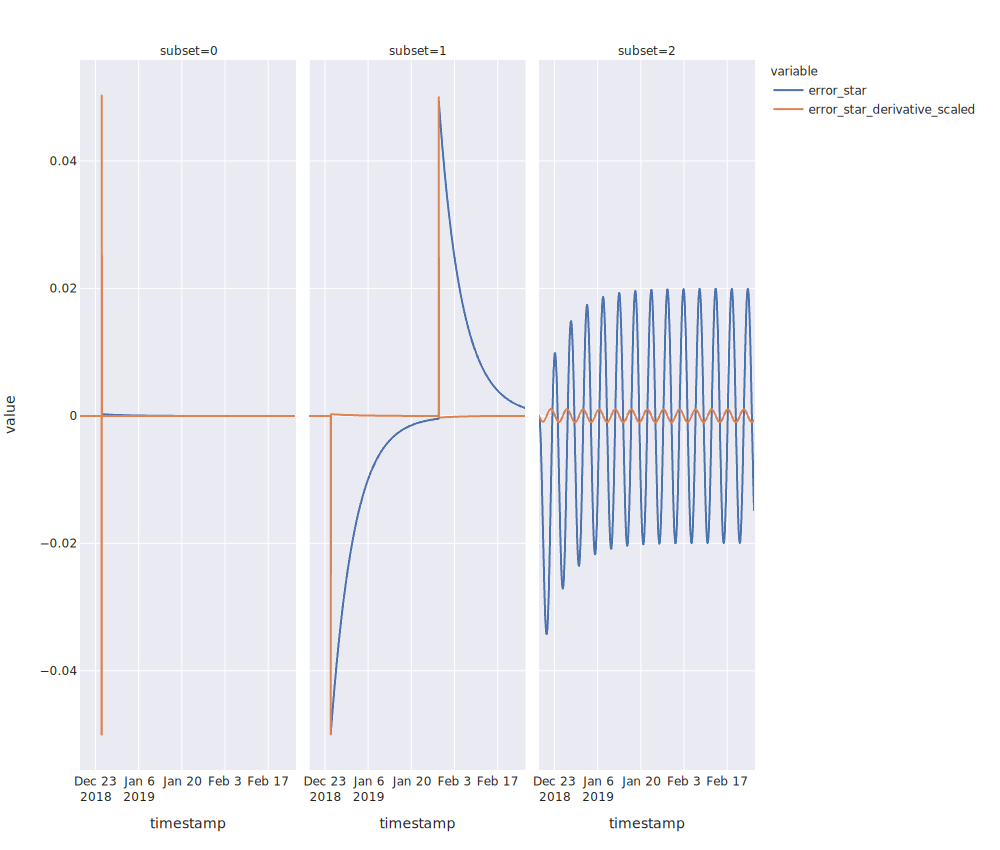

In [18]:
fig = px.line(
    df,
    x='timestamp',
    y=['error_star','error_star_derivative_scaled'],
    facet_col='subset',
    facet_col_wrap=3,
    template='seaborn',
    height=800
)

# fig.show()
fig.write_image('plots/notebook_validation_market_price/error_star_derivative.svg', width=1000, height=850)
from IPython.display import SVG,display
display(SVG(filename='plots/notebook_validation_market_price/error_star_derivative.svg'))

## Controller Metrics

In [19]:
subset = 1
dataset = df.query(f'subset == {subset}')

pv_initial = dataset['market_price'].iloc[0]
pv_max = dataset['market_price'].max()

target_initial = dataset[dataset.target_price > pv_initial].iloc[0]
time_constant = dataset[dataset.target_price - pv_initial >= 0.63 * (pv_max - pv_initial)].iloc[0].timestamp - target_initial.timestamp

print(f'Controller time constant for subset {subset}: {time_constant}')

Controller time constant for subset 1: 7 days 12:00:00
